# Multiple Linear Regression Bike Sharing Assignment

**Problem Statement:**

A bike-sharing system, BoomBikes, has experienced a dip in revenues due to the pandemic.
The company wants to understand the factors affecting bike demand to improve their business strategy.

**The company wants to know:**
1. Which variables are significant in predicting the demand for shared bikes.
2. How well those variables describe the bike demands.

**Goal:**
Develop a model to find the variables which are significant in predicting the demand for shared bikes with the available independent variables. It will be used by the management to understand and manipulate the business strategy to meet the demand levels and meet the customer's expectations.


In [37]:
# Step 1: Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings('ignore')

In [38]:
# Step 2: Reading Dataset and Understanding Data
# Load the dataset
data = pd.read_csv('day.csv')

# Display the first few rows of the dataset
print(data.head())

# Check for missing values
missing_values = data.isnull().sum()
print("Missing values in each column:", missing_values)

# Check the shape of the dataset
print("Shape of the dataset:", data.shape)

# Check the data types and non-null counts of each column
print(data.info())

# Print the column names of the dataset
print("Columns in the dataset:", data.columns)

# Print the axes of the dataframe
print("Axes of the dataframe:", data.axes)

   instant      dteday  season  yr  mnth  holiday  weekday  workingday  \
0        1  01-01-2018       1   0     1        0        6           0   
1        2  02-01-2018       1   0     1        0        0           0   
2        3  03-01-2018       1   0     1        0        1           1   
3        4  04-01-2018       1   0     1        0        2           1   
4        5  05-01-2018       1   0     1        0        3           1   

   weathersit       temp     atemp      hum  windspeed  casual  registered  \
0           2  14.110847  18.18125  80.5833  10.749882     331         654   
1           2  14.902598  17.68695  69.6087  16.652113     131         670   
2           1   8.050924   9.47025  43.7273  16.636703     120        1229   
3           1   8.200000  10.60610  59.0435  10.739832     108        1454   
4           1   9.305237  11.46350  43.6957  12.522300      82        1518   

    cnt  
0   985  
1   801  
2  1349  
3  1562  
4  1600  
Missing values in each col

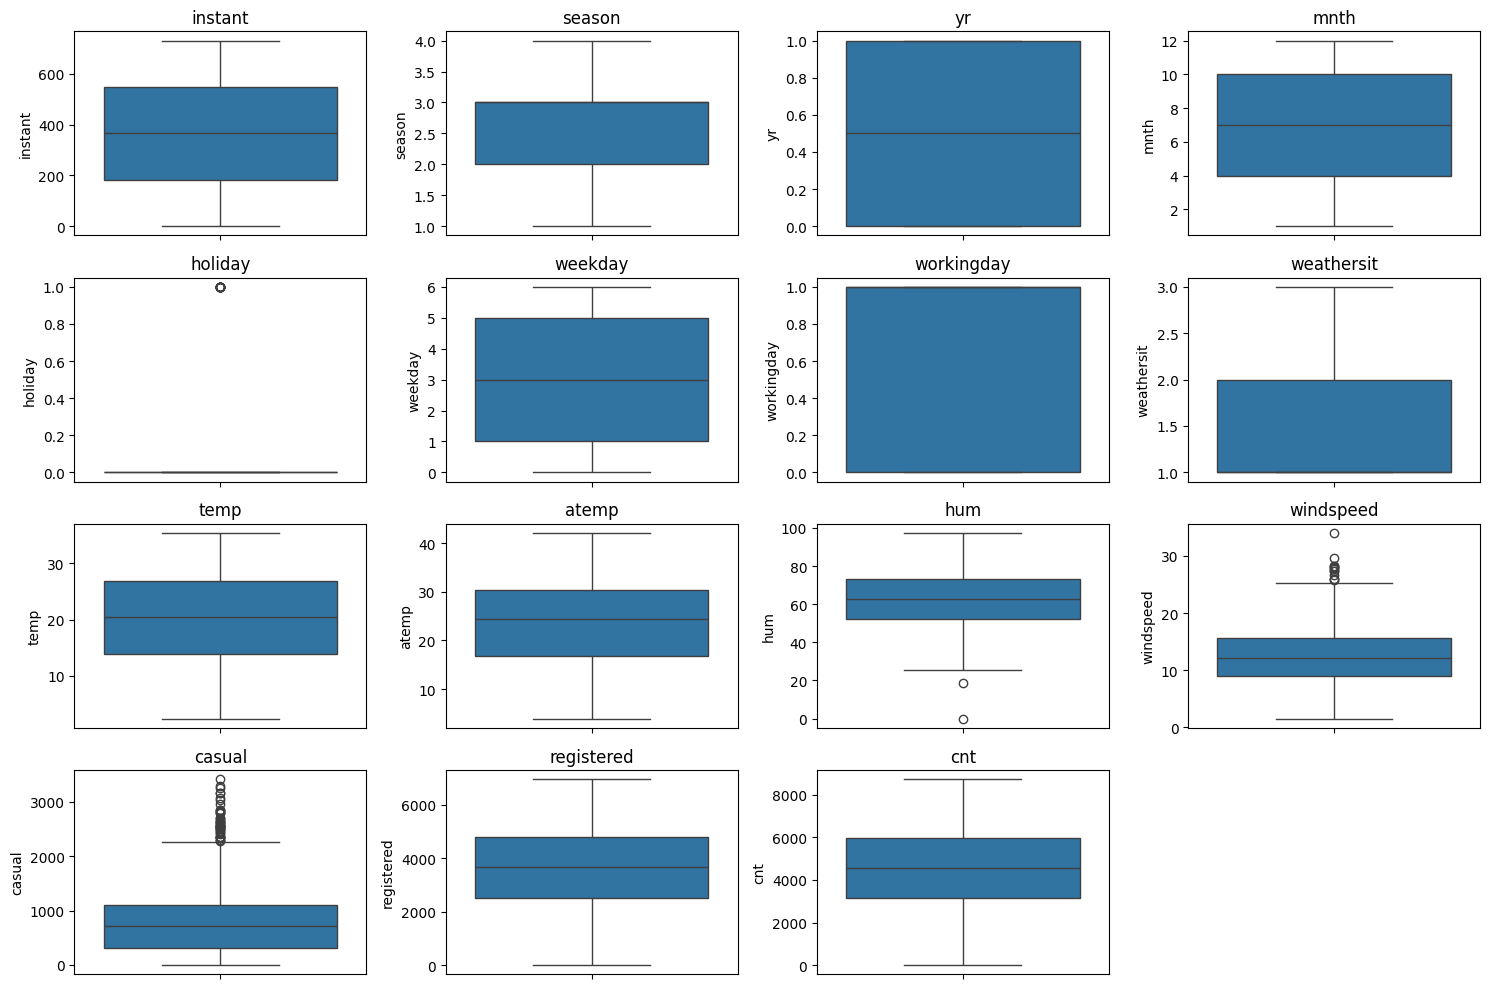

In [39]:
# Step 3: Cleaning Data
# Visualize outliers in numerical columns using box plots
plt.figure(figsize=(15, 10))
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(4, 4, i)
    sns.boxplot(y=data[col])
    plt.title(col)
plt.tight_layout()
plt.show()

In [40]:
# Convert 'dteday' to datetime format
data['dteday'] = pd.to_datetime(data['dteday'], dayfirst=True)

# Extract day, month, and year from 'dteday'
data['day'] = data['dteday'].dt.day
data['month'] = data['dteday'].dt.month
data['year'] = data['dteday'].dt.year

# Drop the original 'dteday' column
data = data.drop('dteday', axis=1)

# Display the first few rows after date extraction
print(data.head())

   instant  season  yr  mnth  holiday  weekday  workingday  weathersit  \
0        1       1   0     1        0        6           0           2   
1        2       1   0     1        0        0           0           2   
2        3       1   0     1        0        1           1           1   
3        4       1   0     1        0        2           1           1   
4        5       1   0     1        0        3           1           1   

        temp     atemp      hum  windspeed  casual  registered   cnt  day  \
0  14.110847  18.18125  80.5833  10.749882     331         654   985    1   
1  14.902598  17.68695  69.6087  16.652113     131         670   801    2   
2   8.050924   9.47025  43.7273  16.636703     120        1229  1349    3   
3   8.200000  10.60610  59.0435  10.739832     108        1454  1562    4   
4   9.305237  11.46350  43.6957  12.522300      82        1518  1600    5   

   month  year  
0      1  2018  
1      1  2018  
2      1  2018  
3      1  2018  
4      

In [41]:
# Drop columns that are not useful for analysis
data.drop(['instant', 'casual', 'registered'], axis=1, inplace=True)

# Inspect the dataframe after dropping columns
print(data.head())
print(data.info())

   season  yr  mnth  holiday  weekday  workingday  weathersit       temp  \
0       1   0     1        0        6           0           2  14.110847   
1       1   0     1        0        0           0           2  14.902598   
2       1   0     1        0        1           1           1   8.050924   
3       1   0     1        0        2           1           1   8.200000   
4       1   0     1        0        3           1           1   9.305237   

      atemp      hum  windspeed   cnt  day  month  year  
0  18.18125  80.5833  10.749882   985    1      1  2018  
1  17.68695  69.6087  16.652113   801    2      1  2018  
2   9.47025  43.7273  16.636703  1349    3      1  2018  
3  10.60610  59.0435  10.739832  1562    4      1  2018  
4  11.46350  43.6957  12.522300  1600    5      1  2018  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   sea

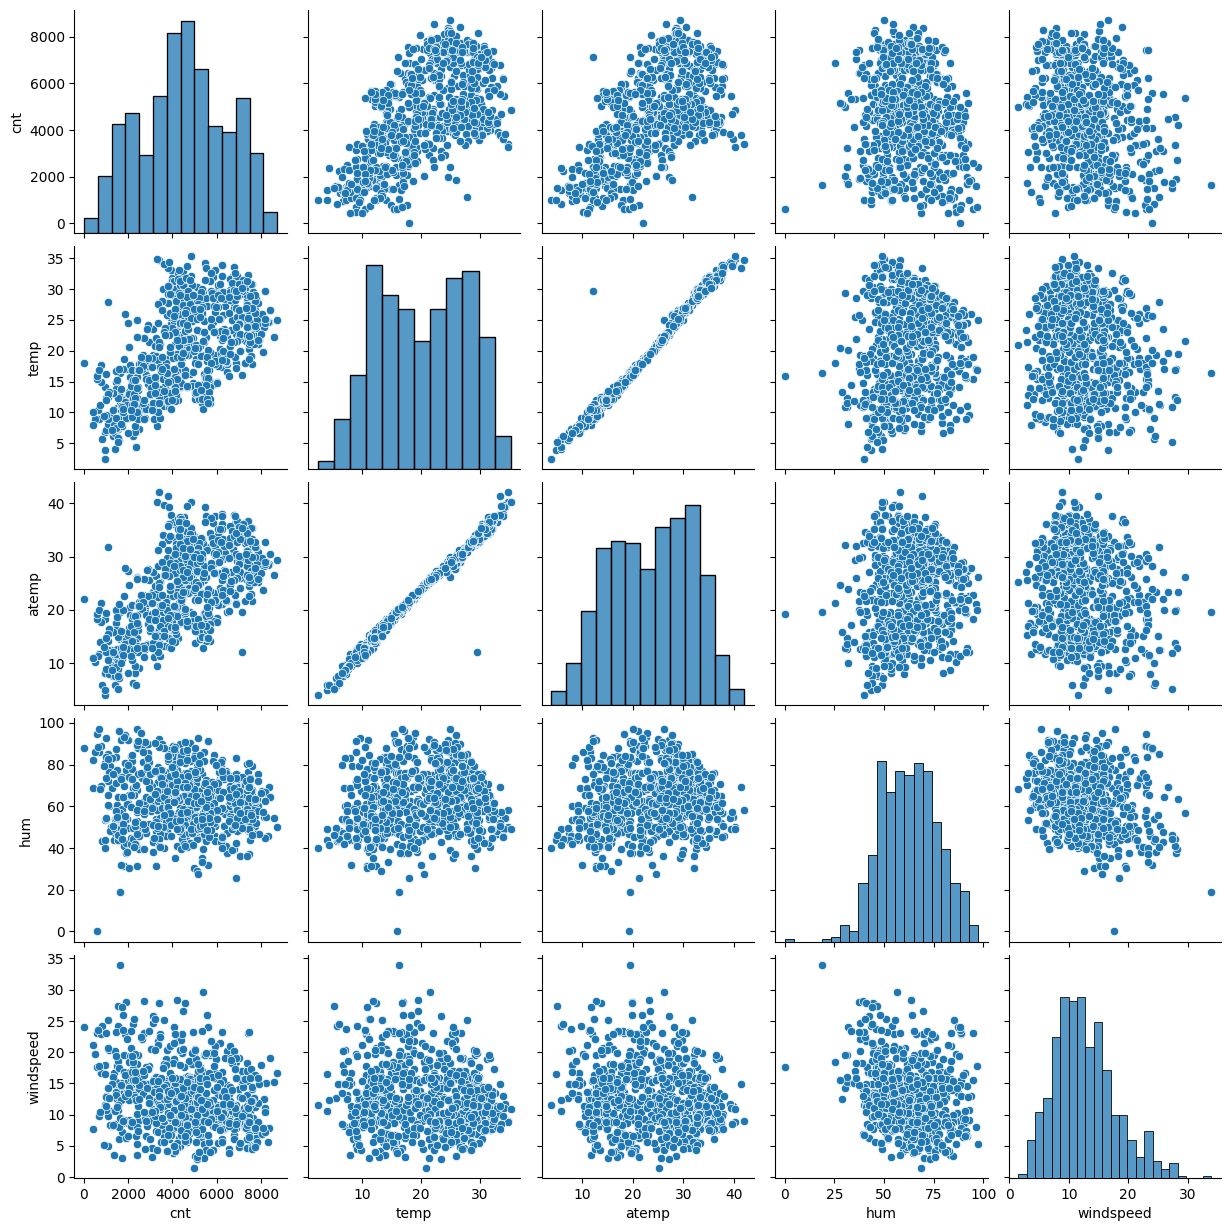

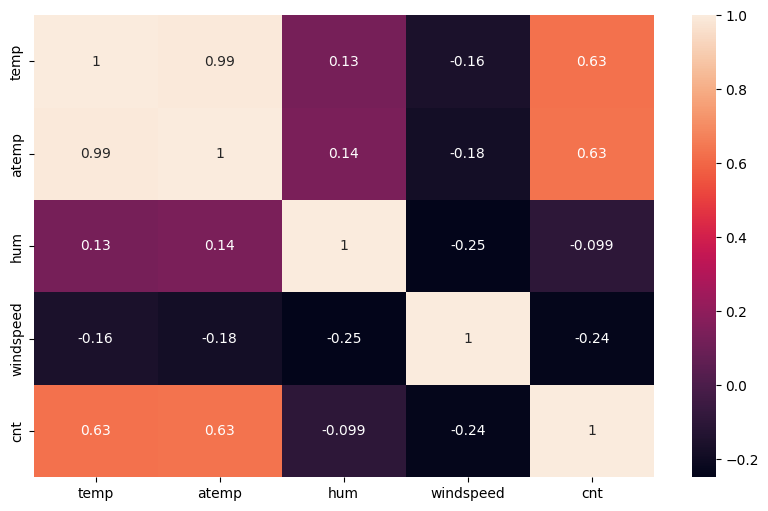

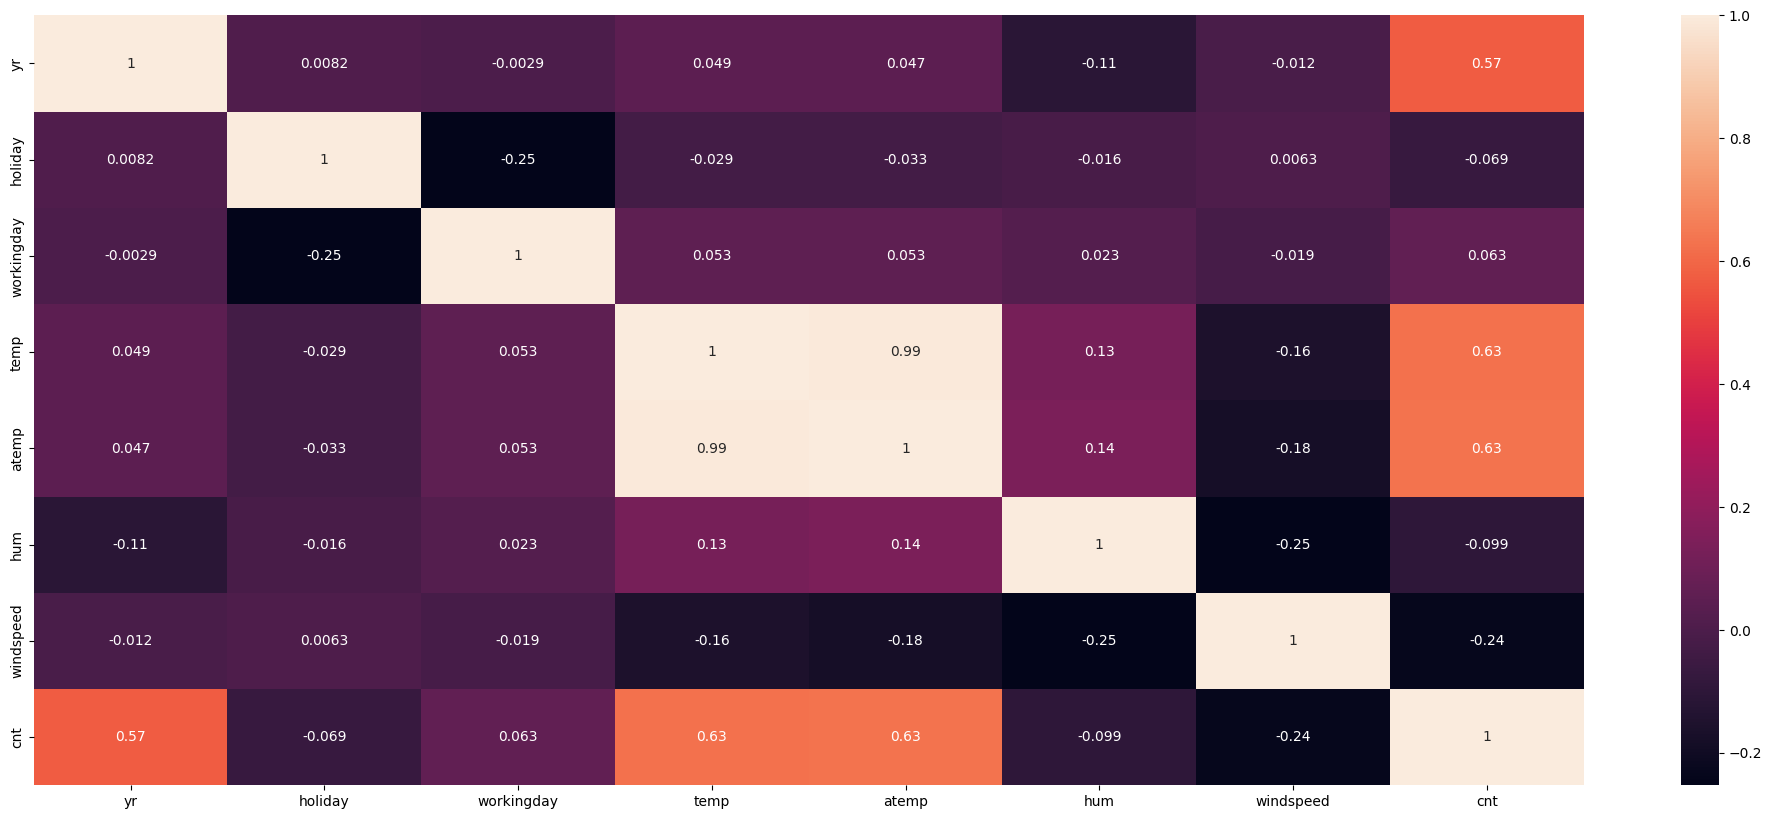

In [42]:
# Step 4: Exploratory Data Analysis (EDA)
# Convert categorical columns to readable labels
data.season.replace({1: "spring", 2: "summer", 3: "fall", 4: "winter"}, inplace=True)
data.weathersit.replace({1: 'good', 2: 'moderate', 3: 'bad', 4: 'severe'}, inplace=True)
data.mnth = data.mnth.replace({1: 'jan', 2: 'feb', 3: 'mar', 4: 'apr', 5: 'may', 6: 'jun', 7: 'jul', 8: 'aug', 9: 'sept', 10: 'oct', 11: 'nov', 12: 'dec'})
data.weekday = data.weekday.replace({0: 'sun', 1: 'mon', 2: 'tue', 3: 'wed', 4: 'thu', 5: 'fri', 6: 'sat'})

# Draw pair plots to check the linear relationship between variables
sns.pairplot(data, vars=['cnt', 'temp', 'atemp', 'hum', 'windspeed'])
plt.show()

# Check the correlation between continuous variables
plt.figure(figsize=(10, 6))
sns.heatmap(data[['temp', 'atemp', 'hum', 'windspeed', 'cnt']].corr(), annot=True)
plt.show()

# Exclude non-numeric columns for the correlation matrix
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns

# Draw a heatmap of the correlation between all numeric variables
plt.figure(figsize=(25, 10))
sns.heatmap(data[numeric_cols].corr(), annot=True)
plt.show()


In [43]:
# Step 5: Data Preparation for Linear Regression
# Create dummy variables for categorical columns
data = pd.get_dummies(data=data, columns=["season", "mnth", "weekday", "weathersit"], drop_first=True)

# Split data into training and test sets
y = data.pop('cnt')
X = data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Feature Scaling for continuous variables
num_vars = ['temp', 'atemp', 'hum', 'windspeed']
scaler = MinMaxScaler()
X_train[num_vars] = scaler.fit_transform(X_train[num_vars])

# Display summary statistics of scaled features
print(X_train.describe())

               yr     holiday  workingday        temp       atemp         hum  \
count  511.000000  511.000000  511.000000  511.000000  511.000000  511.000000   
mean     0.520548    0.027397    0.669276    0.550874    0.526518    0.654174   
std      0.500067    0.163398    0.470935    0.227231    0.212976    0.143648   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.354221    0.353207    0.544598   
50%      1.000000    0.000000    1.000000    0.575304    0.563297    0.659940   
75%      1.000000    0.000000    1.000000    0.745079    0.698389    0.756977   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

        windspeed         day       month         year  
count  511.000000  511.000000  511.000000   511.000000  
mean     0.414873   15.391389    6.587084  2018.520548  
std      0.185619    8.765543    3.418483     0.500067  
min      0.000000    1.000000    1.000000 

In [44]:
# Step 6: Model Building
from sklearn.feature_selection import RFE

# Build a Linear Regression model using SKLearn for RFE
lr = LinearRegression()
lr.fit(X_train, y_train)

# Select top 15 features using RFE
rfe = RFE(lr, n_features_to_select=15)
rfe.fit(X_train, y_train)
selected_columns = X_train.columns[rfe.support_]

# Function to build a model using statsmodels and display summary
def build_model(cols):
    X_train_sm = sm.add_constant(X_train[cols].astype(float))  # Ensure the data is cast to float
    lm = sm.OLS(y_train.astype(float), X_train_sm).fit()  # Ensure the data is cast to float
    return lm

# Function to calculate and print VIFs
def get_vif(cols):
    df1 = X_train[cols].astype(float)  # Ensure the data is cast to float
    vif = pd.DataFrame()
    vif['Features'] = df1.columns
    vif['VIF'] = [variance_inflation_factor(df1.values, i) for i in range(df1.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    return vif.sort_values(by='VIF', ascending=False)

# Build and evaluate the model with selected columns
cols = selected_columns.tolist()
lm = build_model(cols)
vif = get_vif(cols)

print(lm.summary())
print(vif)


                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     190.0
Date:                Wed, 31 Jul 2024   Prob (F-statistic):          2.92e-183
Time:                        00:12:57   Log-Likelihood:                -4136.1
No. Observations:                 511   AIC:                             8300.
Df Residuals:                     497   BIC:                             8360.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.9796    

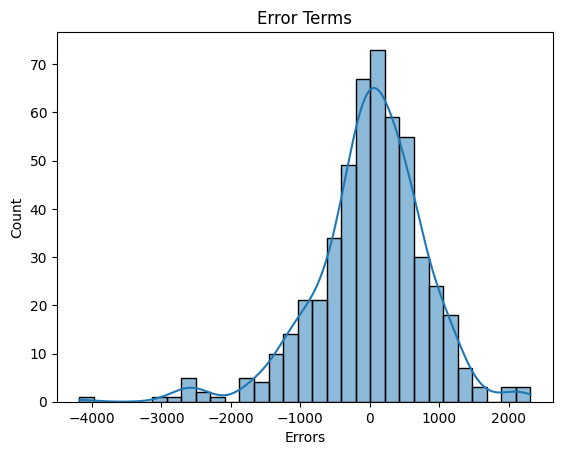

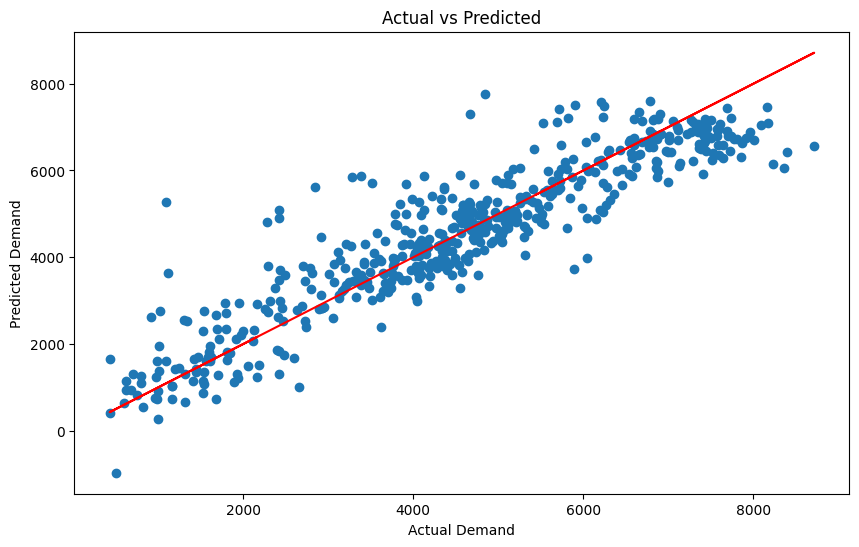

R-squared value for training data: 0.83
R-squared value for test data: 0.82


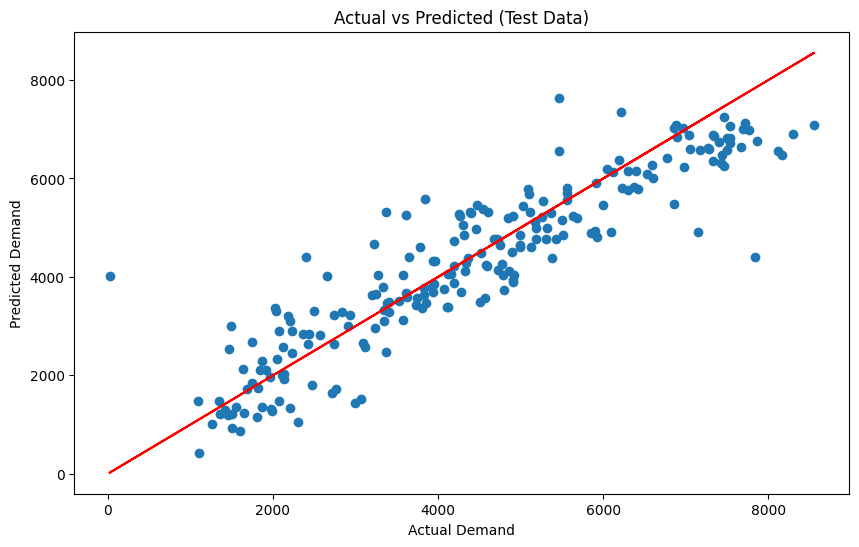

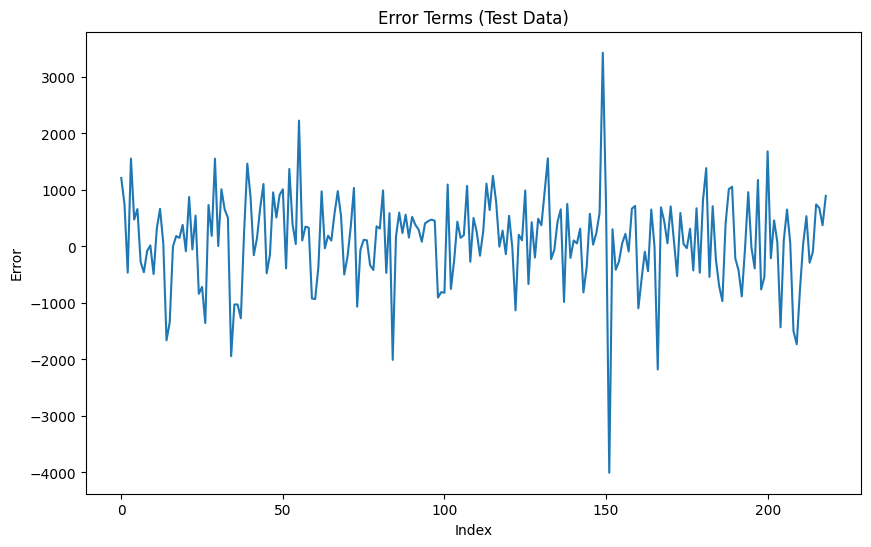

In [45]:
# Step 7: Model Evaluation
# Residual Analysis
y_train_pred = lm.predict(sm.add_constant(X_train[cols]))

# Plot a histogram of the error terms
sns.histplot((y_train - y_train_pred), kde=True)
plt.title('Error Terms')
plt.xlabel('Errors')
plt.show()

# Plot Actual vs Predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_train, y_train_pred)
plt.plot(y_train, y_train, color='red')
plt.title('Actual vs Predicted')
plt.xlabel('Actual Demand')
plt.ylabel('Predicted Demand')
plt.show()

# Calculate and print R-squared value for training data
r2_train = r2_score(y_train, y_train_pred)
print(f'R-squared value for training data: {r2_train:.2f}')

# Scale test data
X_test[num_vars] = scaler.transform(X_test[num_vars])

# Predict values for test data set
y_test_pred = lm.predict(sm.add_constant(X_test[cols]))

# Calculate and print R-squared value for test data
r2_test = r2_score(y_test, y_test_pred)
print(f'R-squared value for test data: {r2_test:.2f}')

# Plot Test vs Predicted test values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred)
plt.plot(y_test, y_test, color='red')
plt.title('Actual vs Predicted (Test Data)')
plt.xlabel('Actual Demand')
plt.ylabel('Predicted Demand')
plt.show()

# Plot Error Terms for test data
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test - y_test_pred)
plt.title('Error Terms (Test Data)')
plt.xlabel('Index')
plt.ylabel('Error')
plt.show()

In [46]:
# Step 8: Making Predictions
# Rebuild the final model with selected features
final_cols = ['yr', 'season_spring', 'mnth_jul', 'season_winter', 'mnth_sept', 'weekday_sun', 'weathersit_good', 'weathersit_moderate', 'temp']
final_model = build_model(final_cols)
print(final_model.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     251.1
Date:                Wed, 31 Jul 2024   Prob (F-statistic):          2.33e-179
Time:                        00:12:59   Log-Likelihood:                -4156.6
No. Observations:                 511   AIC:                             8333.
Df Residuals:                     501   BIC:                             8376.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                -456.0125    

### Conclusion

The final model summary indicates that the most significant features for predicting the bike demand are:
- Year (`yr`)
- Spring season (`season_spring`)
- July (`mnth_jul`)
- Winter season (`season_winter`)
- September (`mnth_sept`)
- Holiday (`weekday_sun`)
- Good weather situation (`weathersit_good`)
- Moderate weather situation (`weathersit_moderate`)
- Temperature (`temp`)

The R-squared value for the training data is approximately 0.83, and for the test data, it is approximately 0.82. This indicates that the model explains about 83% of the variance in the training data and about 82% of the variance in the test data, showing that the model generalizes well to unseen data.

These insights can help BoomBikes understand the demand patterns for shared bikes and adjust their business strategies accordingly to cater to the needs of the people and improve their revenues post-pandemic.
Holiday